In [95]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
#inv - inv_boxcox1p(y, 2.5)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor


import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf

In [96]:
df = pd.read_csv('housing.data', sep='\s+', header=None, names=['CRIM', 'ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])

In [97]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Part 2. Modelling & Evaluation

- ## preprocessing

We will preprocess the data just like part1

In [98]:
df['MEDV'] = np.log1p(df['MEDV'])

In [99]:
df['MEDV'].describe()

count    506.000000
mean       3.085437
std        0.386966
min        1.791759
25%        2.891757
50%        3.100092
75%        3.258097
max        3.931826
Name: MEDV, dtype: float64

In [100]:
for i in df.columns[:-1]:
    print(i)
    print(df[i].skew(), df[i].kurt())
    if i != 'CHAS' and (abs(df[i].skew()) > 0.75):
        df[i] = boxcox1p(df[i], 0.35)
        #df[i] = np.log1p(df[i])

        print(df[i].skew(), df[i].kurt())
    
    print('--------------------------')

CRIM
5.223148798243851 37.13050912952203
1.9740843132332258 4.308580743930477
--------------------------
ZN
2.2256663227354307 4.031510083739155
1.4314701905207694 0.537160832923989
--------------------------
INDUS
0.29502156787351164 -1.2335396011495188
--------------------------
CHAS
3.405904172058746 9.638263777819526
--------------------------
NOX
0.7293079225348787 -0.06466713336542629
--------------------------
RM
0.40361213328874385 1.8915003664993404
--------------------------
AGE
-0.5989626398812962 -0.9677155941626912
--------------------------
DIS
1.0117805793009007 0.4879411222443908
0.5524972546768439 -0.6085593626946499
--------------------------
RAD
1.0048146482182057 -0.8672319936034931
0.7928936001671438 -0.9257488088889918
--------------------------
TAX
0.669955941795016 -1.1424079924768082
--------------------------
PTRATIO
-0.8023249268537809 -0.28509138330538875
-0.9304346714775735 0.014518330337779162
--------------------------
B
-2.8903737121414492 7.226817549260

- ## Split data into two parts and apply MinMax Scaler to the data

we are going to split the data into train set and test set with 8:2 ratio. Moreover, because test data has to be treated as unseen data, we should apply MinMaxScaler to the train set first and then use it to the test set.

In [101]:
num_features = ['CRIM', 'ZN', 'INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

In [102]:
data_num = df[num_features]

Applied one-hot encoding to a categorical feature.

In [103]:
data_catg = pd.get_dummies(df['CHAS'], prefix='CHAS')

In [104]:
y = df['MEDV']

In [105]:
data = pd.concat([data_num, data_catg], axis=1)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 101)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (404, 14)
X_test : (102, 14)
y_train : (404,)
y_test : (102,)


In [107]:
X_train.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_0,CHAS_1
288,0.045232,8.64704,5.32,0.405,6.315,45.6,3.139718,2.788537,293.0,4.938670,20.362356,3.210310,1,0
72,0.089040,0.00000,10.81,0.413,6.065,7.8,2.580296,2.161329,305.0,5.323830,20.239411,2.649902,1,0
471,2.174788,0.00000,18.10,0.532,6.229,90.7,1.824307,5.957627,666.0,5.463359,20.330248,4.315162,1,0
176,0.068677,0.00000,4.05,0.510,6.020,47.2,2.000209,2.492009,296.0,4.938670,20.287173,3.779247,1,0
320,0.159229,0.00000,7.38,0.493,6.426,52.3,2.344869,2.492009,287.0,5.380169,20.362356,3.110005,1,0


In [108]:
#stdSc = StandardScaler()
#X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])
#X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

In [109]:
minmaxSc = MinMaxScaler()
X_train.loc[:, num_features] = minmaxSc.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = minmaxSc.transform(X_test.loc[:, num_features])

In [110]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test =y_test.values
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (404, 14)
X_test : (102, 14)
y_train : (404,)
y_test : (102,)


- ## Models

### 1. Linear Regression

Linear Regression performance result would be used as the basic measure when it comes to evaluation including variance and bias

In [111]:
lr = LinearRegression()

### 2. Ridge Regression (regularization model)

If there is high variance, this model might decrease the variance.
Did some grid search for a hyperparameter

In [112]:
ridge = RidgeCV(cv=5, alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 0.1
Try again for more precision with alphas centered around 0.1
Best alpha : 0.13999999999999999


In [113]:
ridge = Ridge(alpha=alpha)

### 3. Lasso Regression (another regularization model)

In [114]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05


In [115]:
lasso = Lasso(alpha=alpha)

### 4. ElasticNet (Ridge + Lasso)

In [116]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.1
Best alpha : 0.0003
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.085
Best alpha : 0.0003
Now try again for more precision on alpha, with l1_ratio fixed at 0.085 and alpha centered around 0.0003
Best l1_ratio : 0.085
Best alpha : 0.000225


In [117]:
elasticNet = ElasticNet(alpha=alpha, l1_ratio=ratio)

### 5. Kernel Ridge Regression (l2-norm + kernel trick)

In [118]:
KRR = KernelRidge(alpha=0.1399, kernel='polynomial', degree=7, coef0=3.5)

### 6. Random Forest Regression (Bagging)

In [119]:
randomForest = RandomForestRegressor(n_estimators=600, oob_score=True, min_samples_leaf=2, max_features=0.5)

### 7. Gradient Boosting Regression (Boosting)

In [120]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.1,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### 8. XGBoost (Boosting)

In [121]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.0, 
                             learning_rate=0.1, max_depth=4, 
                             min_child_weight=2, n_estimators=2000,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5, silent=1,
                             random_state =7, nthread = -1)

### 9. LightGBM (Boosting)

In [122]:
light_gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =7, min_sum_hessian_in_leaf = 11)

### 10. Simple Stack Model (Average)

In [123]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

### 11. Stack model with a Meta-model

In [124]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X_train, y_train):
        #make dummy list
        self.base_models_ = [list() for x in range(len(self.base_models))]
        #deep copy
        self.meta_model_ = clone(self.meta_model)
        #k-fold spilt
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=101)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        
        # (the number of house prices predicted), (the number of level 0 models)
        out_of_fold_predictions = np.zeros((X_train.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X_train, y_train):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X_train[train_index], y_train[train_index])
                y_pred = instance.predict(X_train[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y_train)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X_test):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X_test) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### 12. Deep Neural Network

In [186]:
feat_cols = [tf.feature_column.numeric_column('x', shape=np.array(X_train).shape[1:])]
input_func = tf.estimator.inputs.numpy_input_fn({'x':X_train}, y_train, batch_size=16, num_epochs=3000, shuffle=True)
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':X_train}, y_train, batch_size=1, num_epochs=1, shuffle=False)
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':X_train}, y_train, batch_size=1, num_epochs=1, shuffle=False)
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x': X_test}, y_test, batch_size=1, num_epochs=1, shuffle=False)
dnn_model = tf.estimator.DNNRegressor(hidden_units=[256, 512, 256, 64],
                                      feature_columns=feat_cols, 
                                      dropout=0.1,
                                      activation_fn=tf.nn.relu,
                                      optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),
                                      batch_norm=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbzhhoamp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ca856f780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train and K-Fold Cross Validation RMSE(root mean square error)

K-Fold Cross Validation RMSE(root mean square error) would be used as a train error, but for convenience, k-fold cross validation is not used when we calculate the Deep Neural Network train error.

In [128]:
def rmse_5cv(model):
    kf = KFold(5, shuffle=True, random_state=101)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [174]:
#for bar plot
d = {'models': ['lr', 'ridge', 'lasso', 'elasticNet','KRR','randomForest','gboost','xgboost','light_gbm','stack_average','stack_meta_model','DNN'], 'cv': [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.], 
     'test': [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.] }
df_rmse =pd.DataFrame(data=d)

In [175]:
score = rmse_5cv(lr)
df_rmse['cv'][0] = score.mean()

In [176]:
score = rmse_5cv(ridge)
df_rmse['cv'][1] = score.mean()

In [177]:
score = rmse_5cv(lasso)
df_rmse['cv'][2] = score.mean()

In [178]:
score = rmse_5cv(elasticNet)
df_rmse['cv'][3] = score.mean()

In [179]:
score = rmse_5cv(KRR)
df_rmse['cv'][4] = score.mean()

In [180]:
score = rmse_5cv(randomForest)
df_rmse['cv'][5] = score.mean()

In [181]:
score = rmse_5cv(gboost)
df_rmse['cv'][6] = score.mean()

In [182]:
score = rmse_5cv(xgboost)
df_rmse['cv'][7] = score.mean()

In [183]:
score = rmse_5cv(light_gbm)
df_rmse['cv'][8] = score.mean()

In [184]:
averaged_models = AveragingModels(models = (elasticNet, gboost, KRR, xgboost))
score = rmse_5cv(averaged_models)
df_rmse['cv'][9] = score.mean()

- here's stack meta model process



1. Split the total training set into two disjoint sets (here train and .holdout )

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.


![stack](img/stack.jpg)

In [185]:
stacked_averaged_models = StackingAveragedModels(base_models = (elasticNet, ridge, gboost, KRR),
                                                 meta_model = lasso)
score = rmse_5cv(stacked_averaged_models)
df_rmse['cv'][10] = score.mean()

In [189]:
dnn_model.train(input_fn=input_func, steps=40000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbzhhoamp/model.ckpt.
INFO:tensorflow:loss = 178.39738, step = 1
INFO:tensorflow:global_step/sec: 604.347
INFO:tensorflow:loss = 1.7649081, step = 101 (0.166 sec)
INFO:tensorflow:global_step/sec: 845.634
INFO:tensorflow:loss = 4.5736995, step = 201 (0.118 sec)
INFO:tensorflow:global_step/sec: 847.326
INFO:tensorflow:loss = 2.5050454, step = 301 (0.118 sec)
INFO:tensorflow:global_step/sec: 844.965
INFO:tensorflow:loss = 2.197303, step = 401 (0.118 sec)
INFO:tensorflow:global_step/sec: 847.66
INFO:tensorflow:loss = 1.3260994, step = 501 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.532
INFO:tensorflow:loss = 0.6739668, step = 601 (0.118 sec)
INFO:tensorflow:global_step/sec: 846.932
INFO:tensorflow:lo

INFO:tensorflow:loss = 0.8604207, step = 8001 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.429
INFO:tensorflow:loss = 0.8246075, step = 8101 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.843
INFO:tensorflow:loss = 0.831802, step = 8201 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.821
INFO:tensorflow:loss = 1.7484044, step = 8301 (0.118 sec)
INFO:tensorflow:global_step/sec: 850.113
INFO:tensorflow:loss = 1.1522936, step = 8401 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.546
INFO:tensorflow:loss = 0.98780453, step = 8501 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.159
INFO:tensorflow:loss = 0.69049644, step = 8601 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.522
INFO:tensorflow:loss = 1.5795592, step = 8701 (0.118 sec)
INFO:tensorflow:global_step/sec: 846.725
INFO:tensorflow:loss = 1.061601, step = 8801 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.467
INFO:tensorflow:loss = 1.5389185, step = 8901 (0.118 sec)
INFO:tensorflow:global_step/sec: 845.379
INFO:tenso

INFO:tensorflow:global_step/sec: 848.242
INFO:tensorflow:loss = 0.9242103, step = 16301 (0.118 sec)
INFO:tensorflow:global_step/sec: 845.072
INFO:tensorflow:loss = 1.2304581, step = 16401 (0.118 sec)
INFO:tensorflow:global_step/sec: 847.74
INFO:tensorflow:loss = 0.87679076, step = 16501 (0.118 sec)
INFO:tensorflow:global_step/sec: 847.706
INFO:tensorflow:loss = 1.284941, step = 16601 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.604
INFO:tensorflow:loss = 1.4628489, step = 16701 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.91
INFO:tensorflow:loss = 1.1282966, step = 16801 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.694
INFO:tensorflow:loss = 1.2489524, step = 16901 (0.118 sec)
INFO:tensorflow:global_step/sec: 850.592
INFO:tensorflow:loss = 1.4547457, step = 17001 (0.118 sec)
INFO:tensorflow:global_step/sec: 849.552
INFO:tensorflow:loss = 0.7694609, step = 17101 (0.118 sec)
INFO:tensorflow:global_step/sec: 848.809
INFO:tensorflow:loss = 1.244573, step = 17201 (0.118 sec)
INF

In [190]:
y_train_pred = []
for pred in dnn_model.predict(input_fn=train_input_func):
    y_train_pred.append(pred['predictions'][0])
df_rmse['cv'][11] = np.sqrt(mean_squared_error(y_train_pred,y_train))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbzhhoamp/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


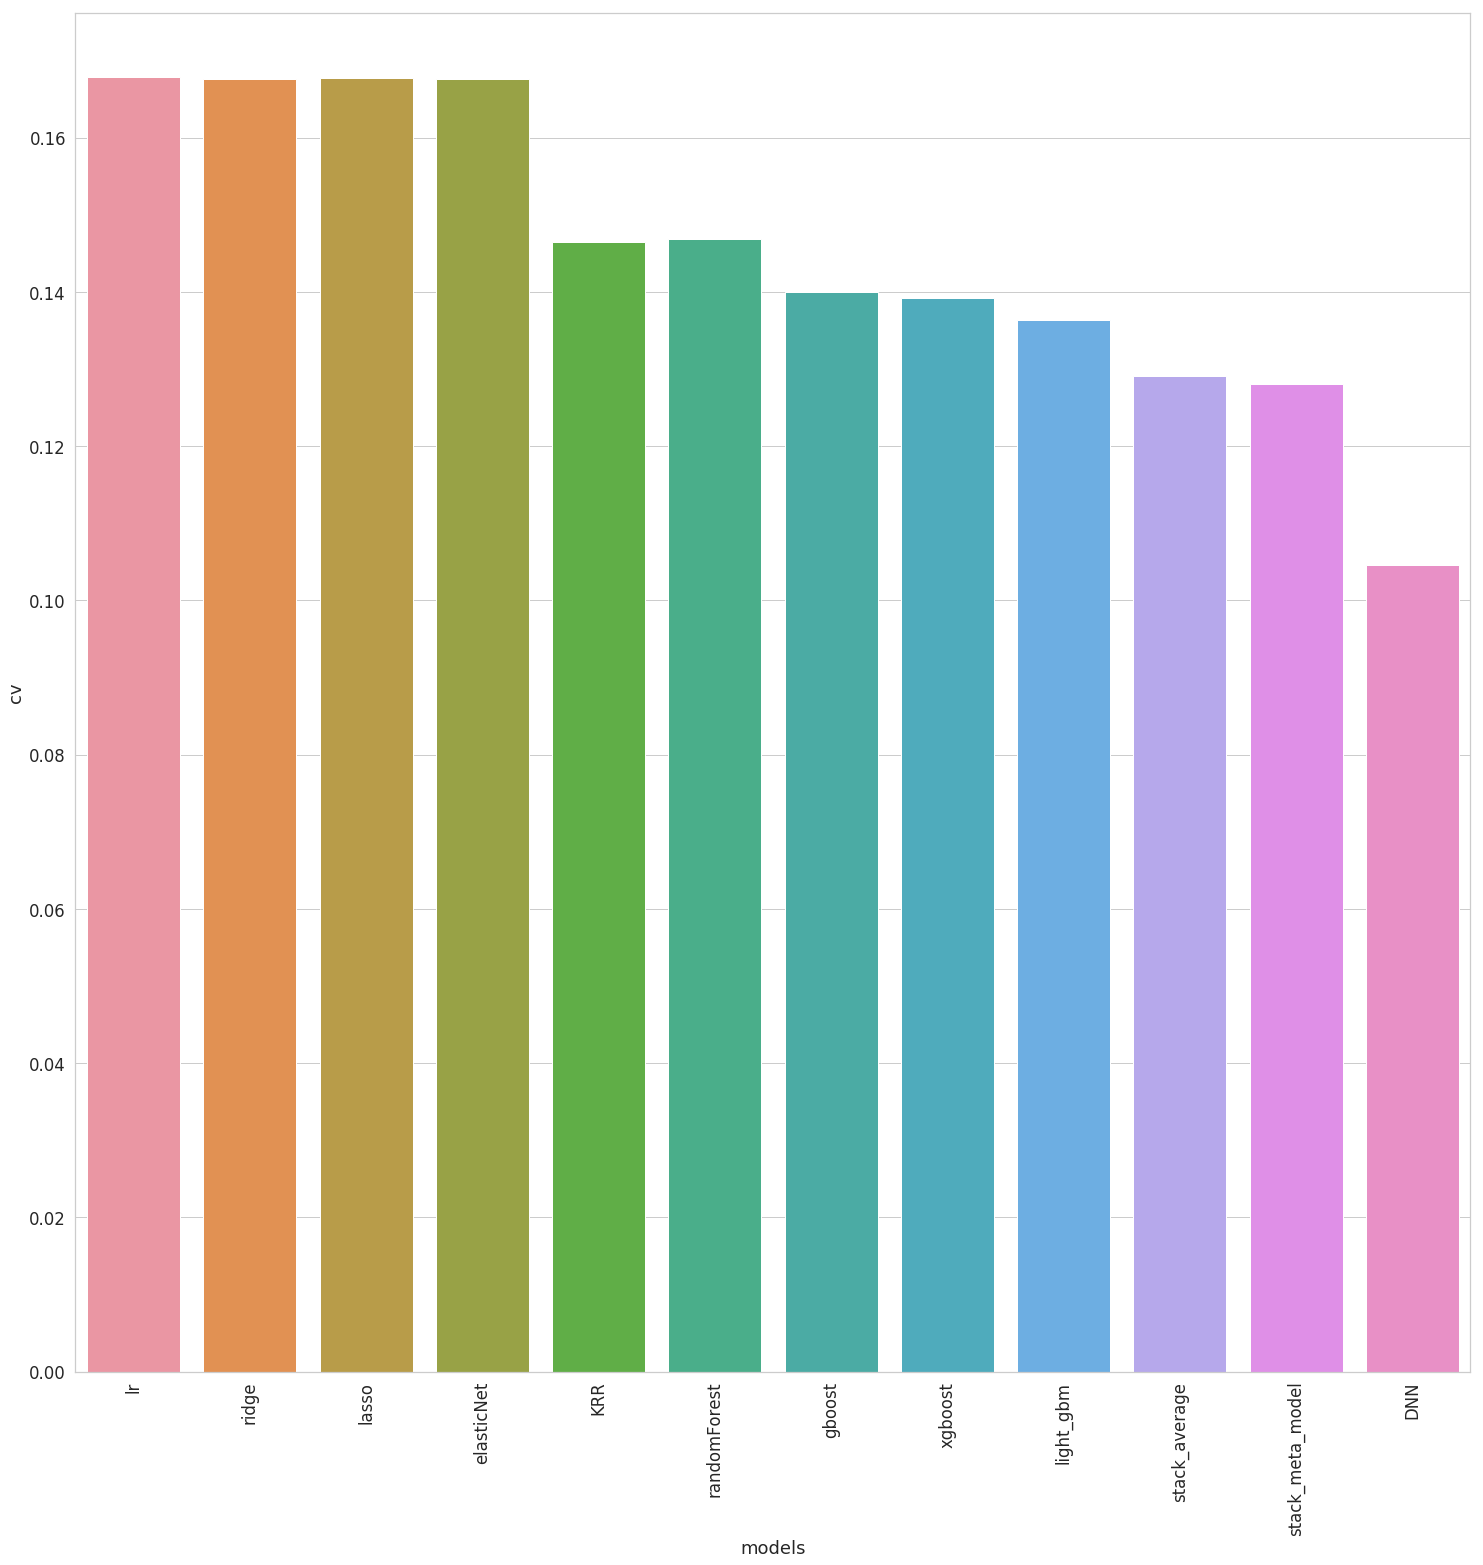

In [191]:
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(25,25))
sns.set(font_scale=1.5)

sns.barplot(x = 'models', y = 'cv', data=df_rmse)
plt.xticks(rotation=90)
plt.show()

As you can see the bar plot, basic 4 models(linear,ridge,lasso and elasticnet) have higher bias than other advanced models and Deep Neural Network performed best on a train set.

- ## Evaluation on test (or dev) set

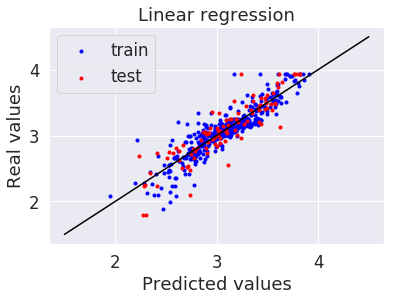

In [192]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [193]:
df_rmse['test'][0] = np.sqrt(mean_squared_error(y_test_pred,y_test))

In [194]:
ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)
df_rmse['test'][1] = np.sqrt(mean_squared_error(y_test_pred,y_test))

In [195]:
lasso.fit(X_train, y_train)
y_test_pred = lasso.predict(X_test)
df_rmse['test'][2] = np.sqrt(mean_squared_error(y_test_pred,y_test))

In [197]:
elasticNet.fit(X_train, y_train)
y_test_pred = elasticNet.predict(X_test)
df_rmse['test'][3] = np.sqrt(mean_squared_error(y_test_pred,y_test))

In [198]:
KRR.fit(X_train, y_train)
y_test_pred = KRR.predict(X_test)
df_rmse['test'][4] = np.sqrt(mean_squared_error(y_test_pred,y_test))

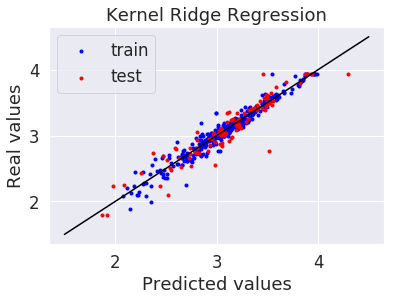

In [199]:
y_train_pred = KRR.predict(X_train)
y_test_pred = KRR.predict(X_test)
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Kernel Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [200]:
randomForest.fit(X_train, y_train)
y_test_pred = randomForest.predict(X_test)
df_rmse['test'][5] = np.sqrt(mean_squared_error(y_test_pred,y_test))

In [201]:
gboost.fit(X_train, y_train)
y_test_pred = gboost.predict(X_test)
df_rmse['test'][6] = np.sqrt(mean_squared_error(y_test_pred,y_test))

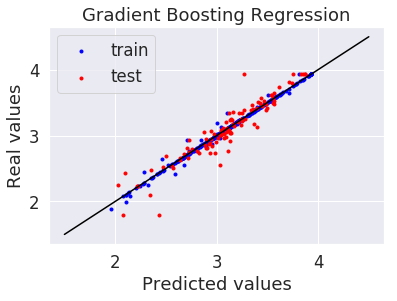

In [202]:
y_train_pred = gboost.predict(X_train)
y_test_pred = gboost.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Gradient Boosting Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [203]:
xgboost.fit(X_train, y_train)
y_test_pred = xgboost.predict(X_test)
df_rmse['test'][7] = np.sqrt(mean_squared_error(y_test_pred,y_test))

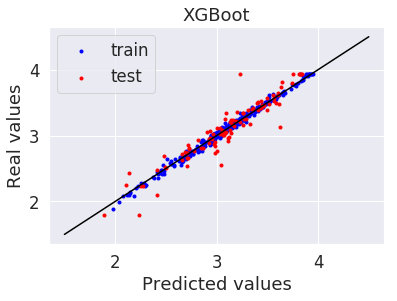

In [204]:
y_train_pred = xgboost.predict(X_train)
y_test_pred = xgboost.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("XGBoot")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [205]:
light_gbm.fit(X_train, y_train)
y_test_pred = light_gbm.predict(X_test)
df_rmse['test'][8] = np.sqrt(mean_squared_error(y_test_pred,y_test))

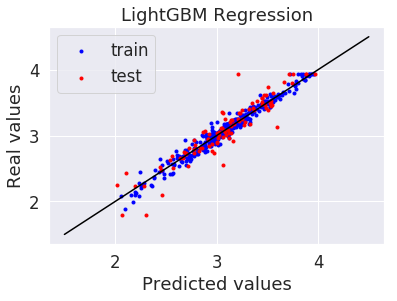

In [206]:
y_train_pred = light_gbm.predict(X_train)
y_test_pred = light_gbm.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("LightGBM Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [207]:
averaged_models.fit(X_train, y_train)
averaged_models_pred = averaged_models.predict(X_test)
df_rmse['test'][9] = np.sqrt(mean_squared_error(averaged_models_pred,y_test))

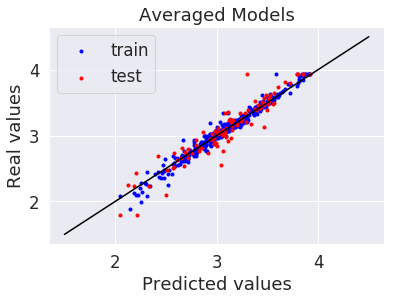

In [208]:
y_train_pred = averaged_models.predict(X_train)
y_test_pred = averaged_models.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Averaged Models")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [209]:
stacked_averaged_models.fit(X_train, y_train)
stacked_averaged_models_pred = stacked_averaged_models.predict(X_test)

In [211]:
xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

In [212]:
average = (stacked_averaged_models_pred*0.5 + xgboost_pred * 0.5)

In [213]:
df_rmse['test'][10]  = np.sqrt(mean_squared_error(average,y_test))

In [214]:
y_test_pred = []
for pred in dnn_model.predict(input_fn=eval_input_func):
    y_test_pred.append(pred['predictions'][0])
df_rmse['test'][11] = np.sqrt(mean_squared_error(y_test_pred,y_test))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbzhhoamp/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbzhhoamp/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbzhhoamp/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


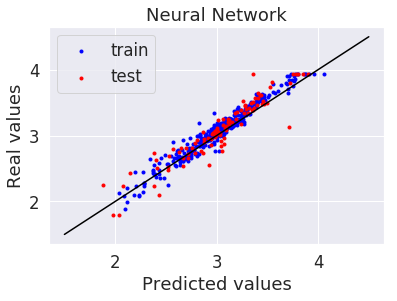

In [215]:
y_train_pred = []
for pred in dnn_model.predict(input_fn=train_input_func):
    y_train_pred.append(pred['predictions'][0])
    
y_test_pred = []
for pred in dnn_model.predict(input_fn=eval_input_func):
    y_test_pred.append(pred['predictions'][0])

plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Neural Network")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

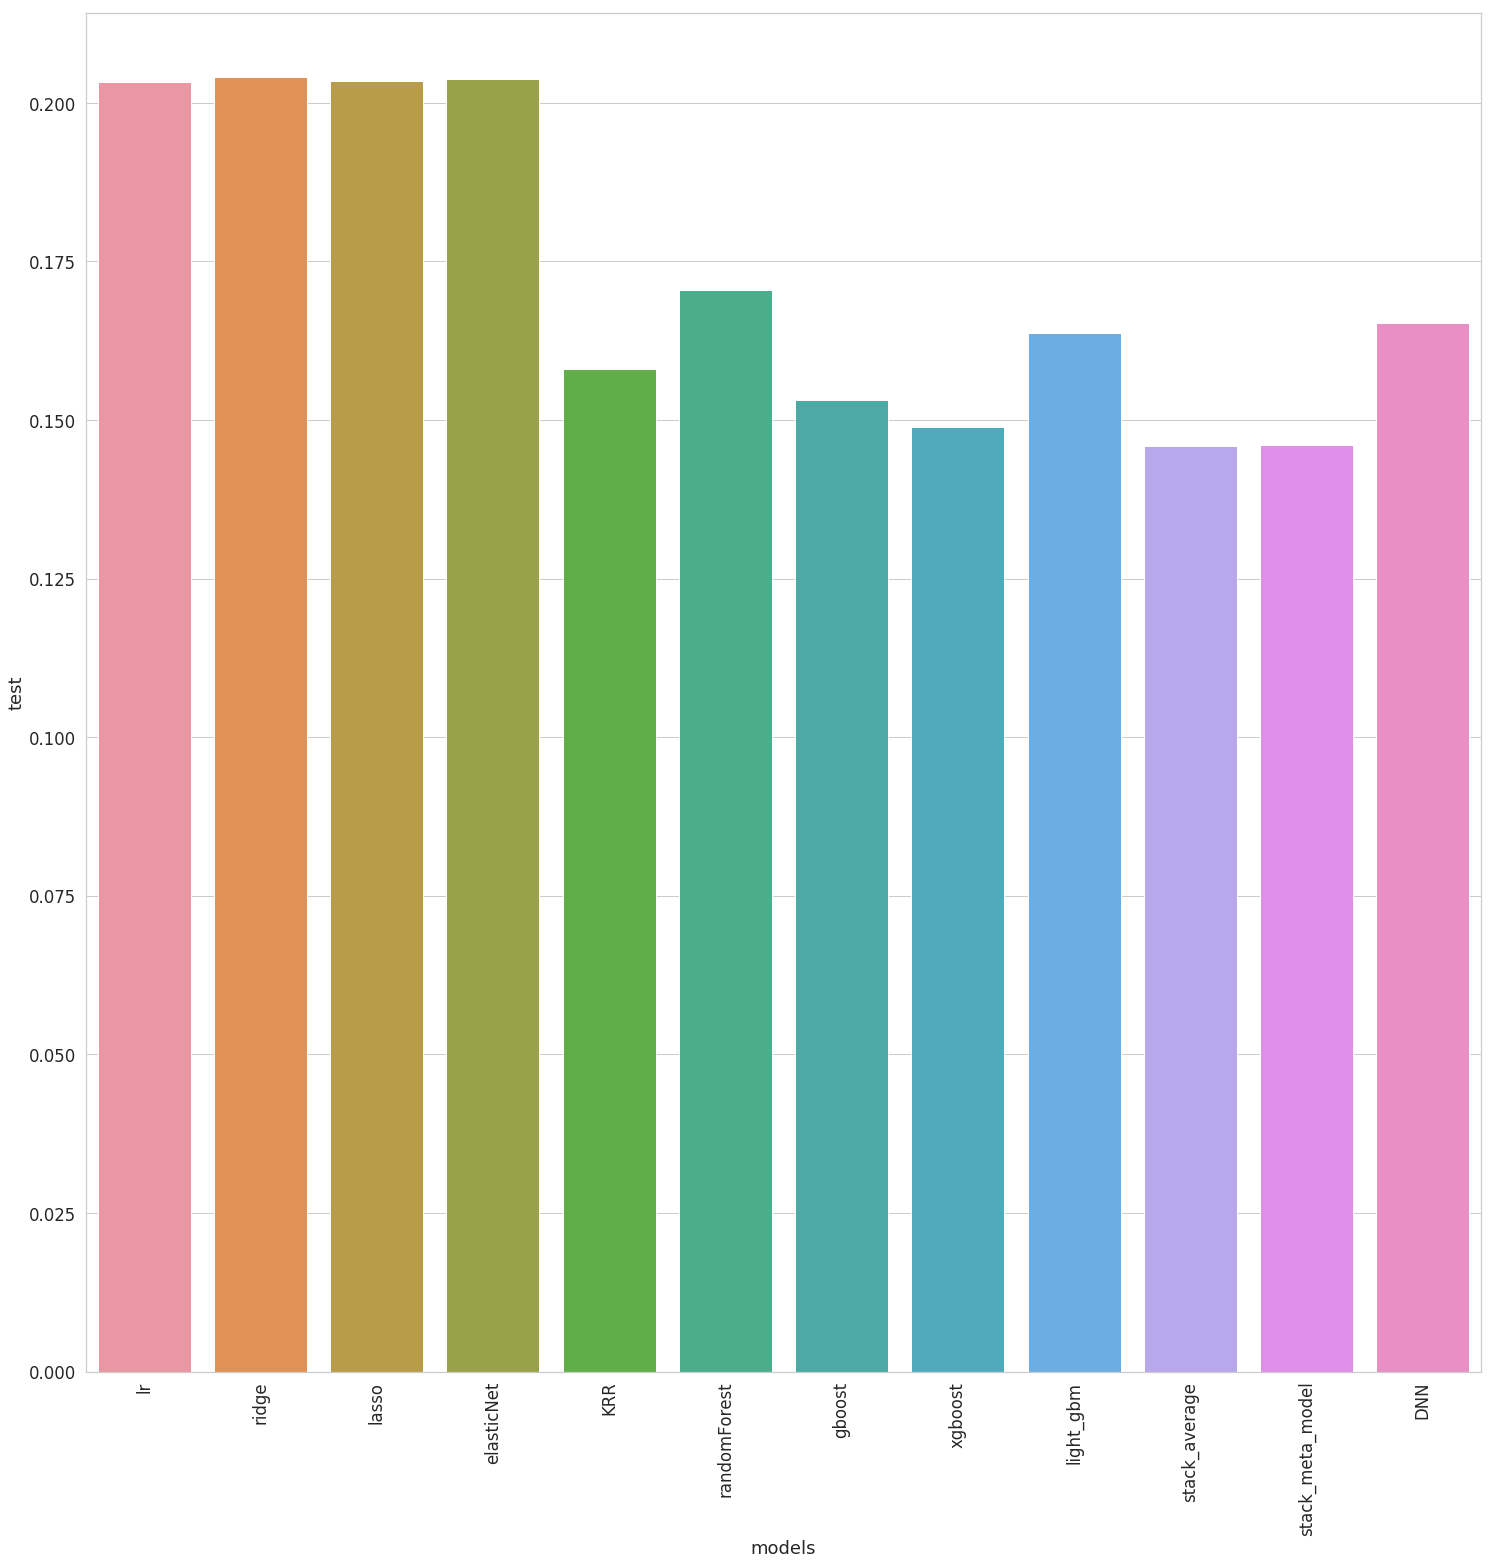

In [216]:
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(25,25))
sns.set(font_scale=1.5)

sns.barplot(x = 'models', y = 'test', data=df_rmse)
plt.xticks(rotation=90)
plt.show()

This plot shows RMSE on a test set(unseen data).
It seems that DNN was our best regressor on a cross validation, but on the test set, DNN got high variance. Simeple Stack Average model and stack meta model got the lowest RSME.